In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [23]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

warnings.filterwarnings('ignore')

In [36]:
df_train = pd.read_csv('/home/siarhei/Programming/ML/Data/House-Prices/train.csv', index_col="Id")
df_test = pd.read_csv('/home/siarhei/Programming/ML/Data/House-Prices/test.csv', index_col="Id")

y = df_train.pop('SalePrice')

df_all_data = pd.concat([df_train, df_test])
df_all_data.shape

df_merged = pd.concat([df_train, df_test])

pd.set_option('display.max_rows', False)

print(f'Test : {df_test.shape}\nTrain : {df_train.shape}\nAll Data : {df_merged.shape}')

Test : (1459, 79)
Train : (1460, 79)
All Data : (2919, 79)


df_train.head(100)

df_test.head(100)

df_all_data.info()

df_train.describe().T

with open('/home/siarhei/Programming/ML/Data/House-Prices/data_description.txt') as f:
    [print(line, end='') for line in f.readlines()]

<AxesSubplot:ylabel='%'>

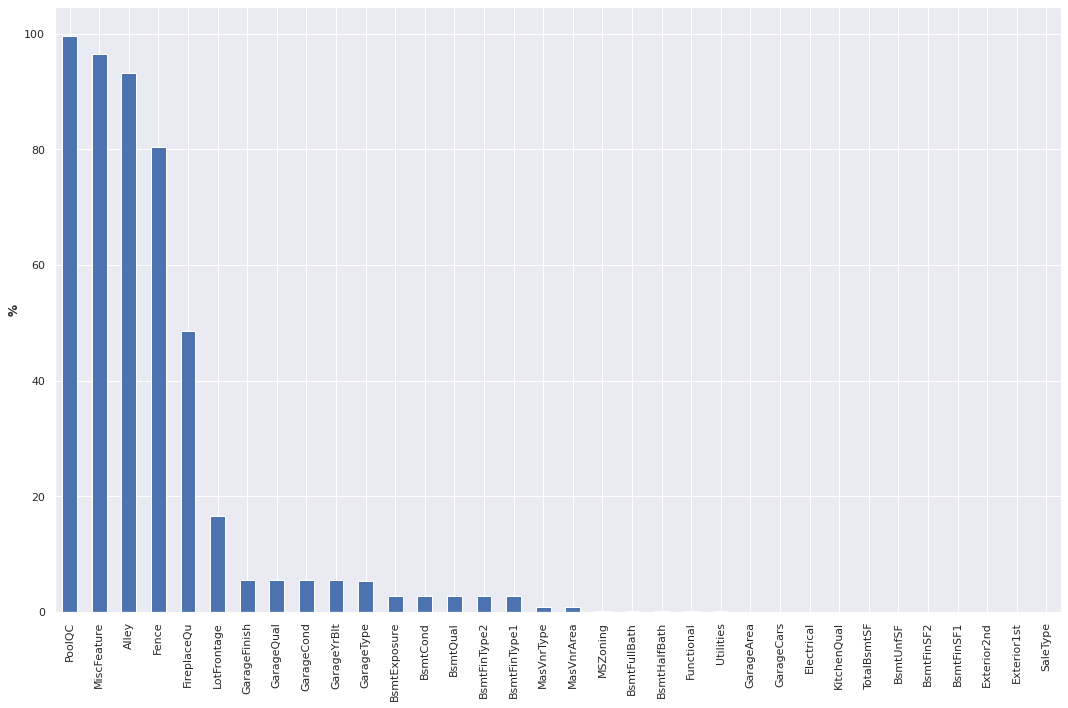

In [37]:
#Check percent of missing values
df_all_data = df_all_data.isna().sum()[df_all_data.isna().sum() > 0].sort_values(ascending = False)/len(df_all_data)*100
df_all_data.plot.bar(figsize = (15,10), ylabel = '%')

In [41]:
# Construction year of the newest house
df_merged.YearBuilt.max() # 2010

def clean(df):
    
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    
    # Some values of YrSold are also corrupt i.e. house was sold before it was built! We'll replace them with the year the house was built
    df["YrSold"] = df["YrSold"].where(df.YrSold >= df.YearBuilt, df.YearBuilt)
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={"1stFlrSF": "FirstFlrSF",
                       "2ndFlrSF": "SecondFlrSF",
                       "3SsnPorch": "Threeseasonporch"},
              inplace=True)
    
    return df


df_merged = clean(df_merged)

In [45]:
#???????????????????????????????????????????????????????????????????????????????????????????????????????
from pandas.api.types import CategoricalDtype
# pandas calls the categories as "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"] # poor, fair, typical?, good, excellent
ten_levels = list(range(10))

ordered_levels = {
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# add a new level 'None' in each ordinal categorical feature so that we can replace NAs with a category 'None'.
ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()}

def encode(df):
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True)) # changing data type to ordinal with (ordered  = True) 
    return df

# encode ordered categorical features
df_merged = encode(df_merged)

In [46]:
# The 'MSSubClass' is a string/unordered(nominal) categorical variable but encoded as `int` type. So we need to convert the data type.  
df_merged['MSSubClass'] = df_merged.MSSubClass.astype('str')

In [47]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("O"):
        df[name] = df[name].fillna("None") # We made a new category 'None' during encoding so we can fill 'NA' with 'None'
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None") # We made a new category 'None' during encoding so we can fill 'NA' with 'None' 
        
    return df

# impute NAs
df_merged = impute(df_merged)

# Check if there are still NAs
df_merged.isna().sum()[df_merged.isna().sum() > 0].sort_values(ascending = False)

Series([], dtype: int64)

In [48]:
numeric_features = []
for feature in df_merged.select_dtypes("number"):
    numeric_features.append(feature)
    
print('number of numeric features: ', len(numeric_features))

number of numeric features:  35


In [49]:
def label_encode(df):
    X = df.copy()
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]).columns:
        X[colname] = X[colname].cat.codes
    return X

In [50]:
def one_hot_encode(df):
    X = df.copy()
    X = pd.get_dummies(X, drop_first=True)
    return X

In [51]:
df_merged = label_encode(df_merged)

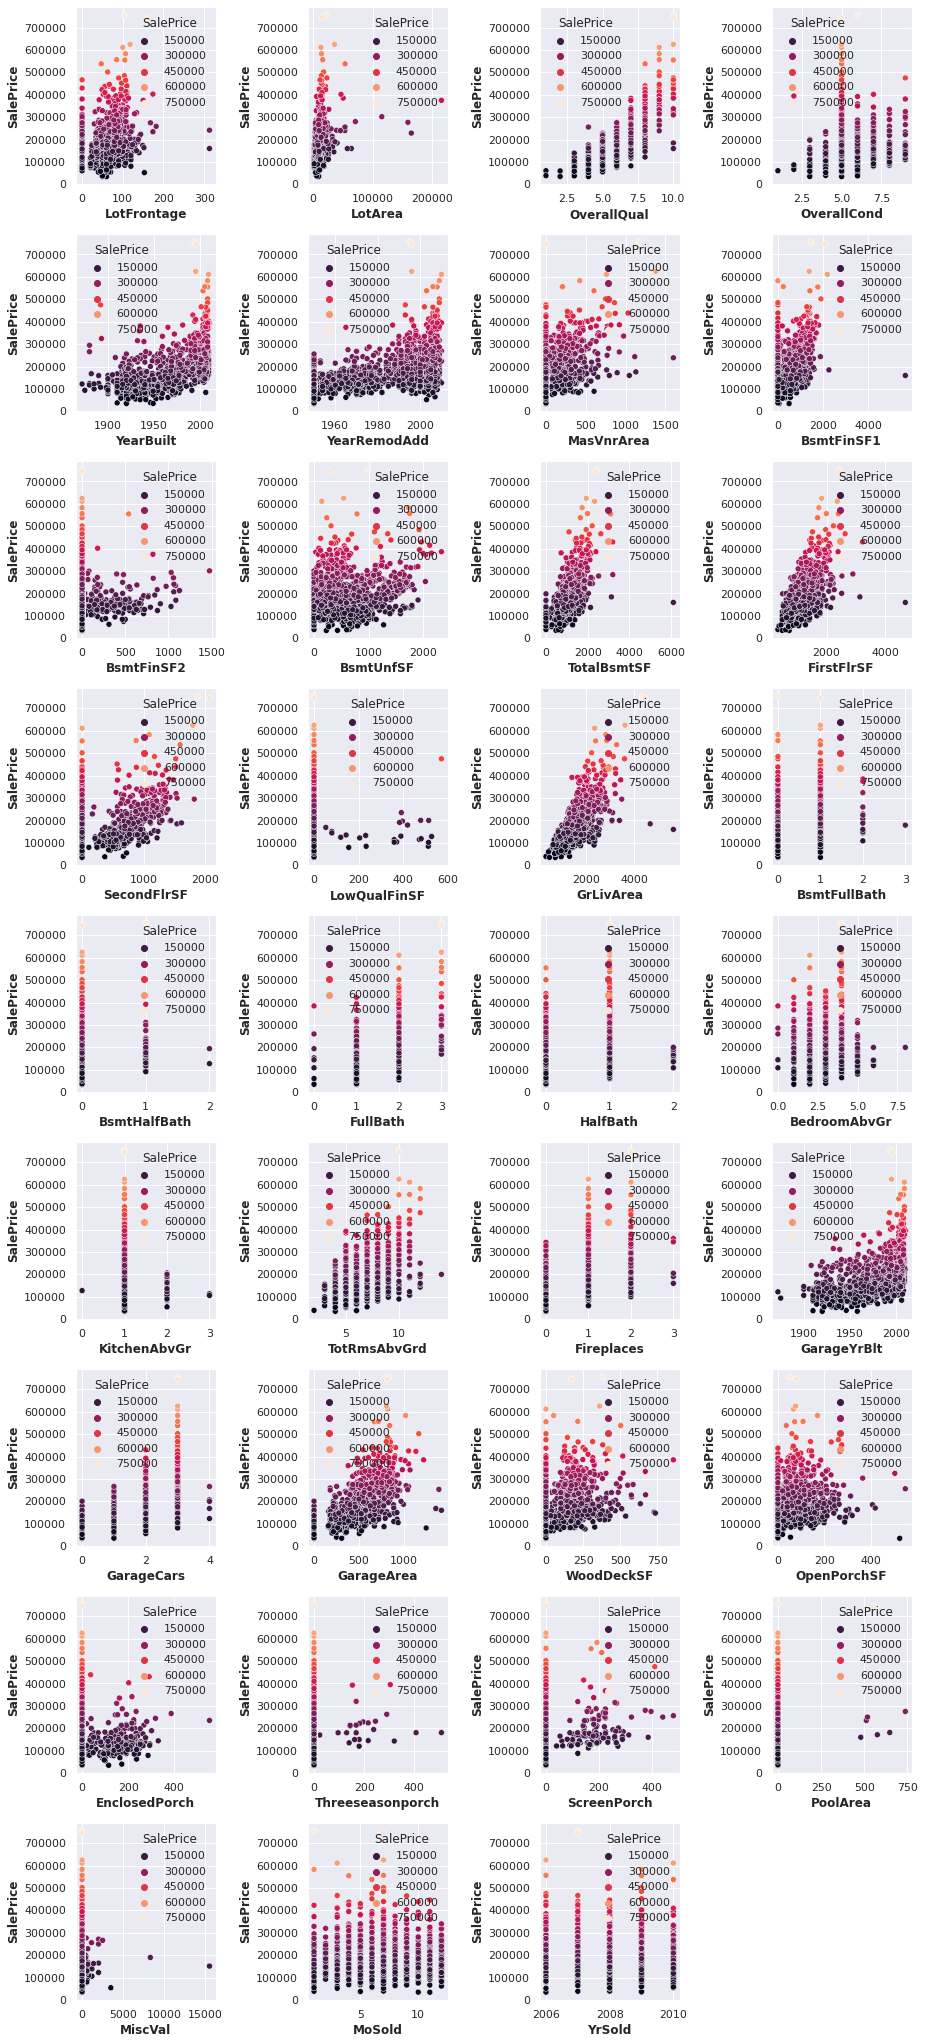

In [52]:
df_train = df_merged.loc[y.index, :]
df_train = df_train.join(y)

fig, axs = plt.subplots( figsize=(13, 110))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 4, i)
    sns.scatterplot(x=col, y='SalePrice', hue='SalePrice', palette="rocket", data=df_train)

# Feature Engineering

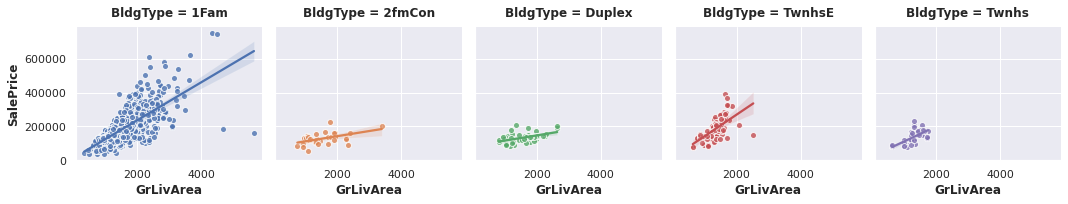

In [54]:
feature = "GrLivArea"

sns.lmplot(x=feature, y="SalePrice", hue="BldgType", col="BldgType",
           data=df_train, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.tight_layout()
plt.show()

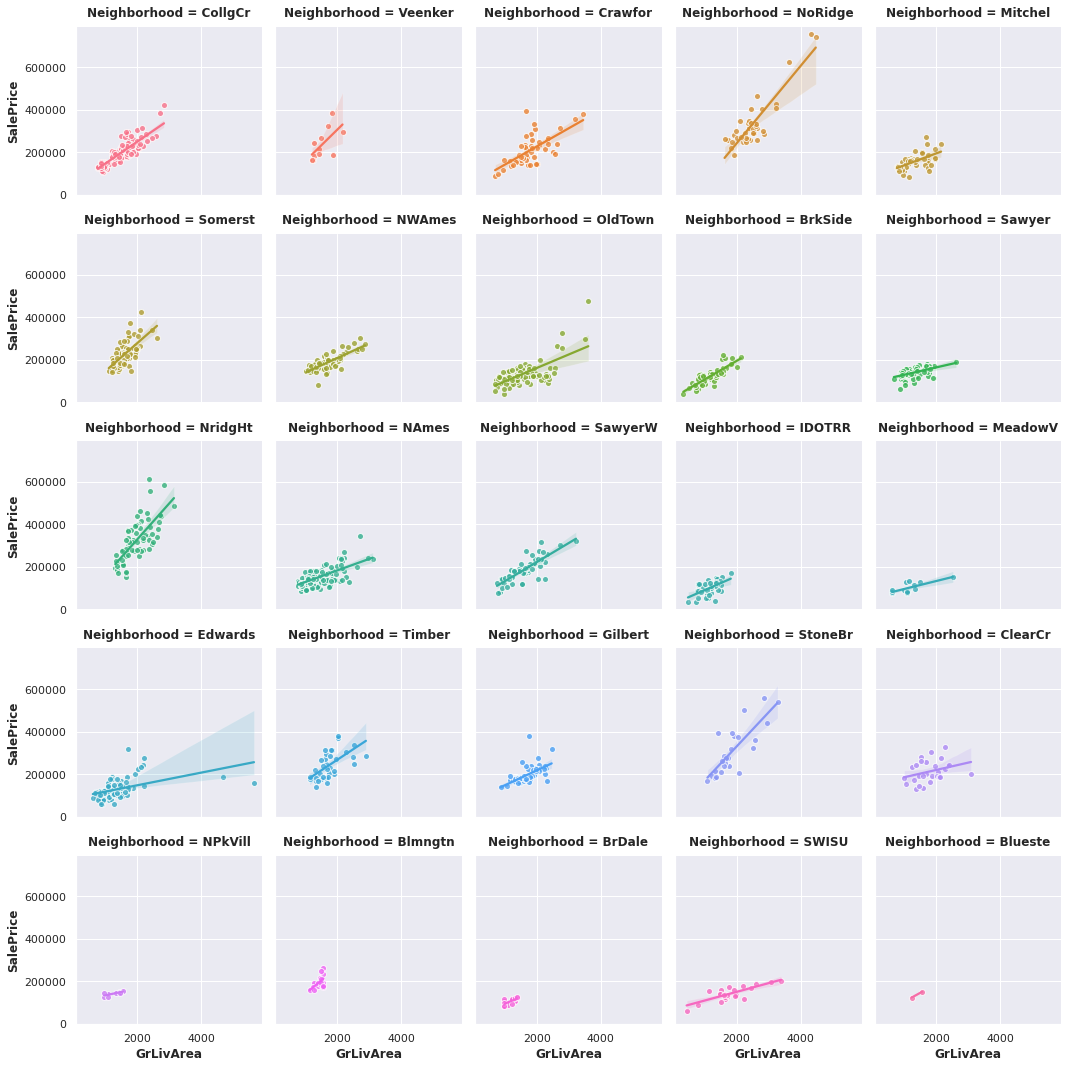

In [55]:
sns.lmplot(x=feature, y="SalePrice", hue="Neighborhood", col="Neighborhood",
           data=df_train, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.show()

# Create Features with Pandas

In [60]:
# As the metric for loss is RMSLE, we need to log-transform y
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def rmsle(X, y, model=XGBRegressor()):
    X = X.copy()
    X = pd.get_dummies(X, drop_first=True)
    score = -cross_val_score(model, X, np.log1p(y), cv=5, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

df_train = df_merged.loc[y.index, :]
df_train = df_train.join(y)
df_test = df_merged.loc[df_test.index, :]
print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


In [61]:
X = df_train.copy()
y = X.pop("SalePrice")

score = rmsle(X, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13858 RMSLE


In [62]:
X = df_train.copy()
y = X.pop("SalePrice")

score = rmsle(X, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13858 RMSLE


# Additional Features from Principal Component Analysis (PCA)

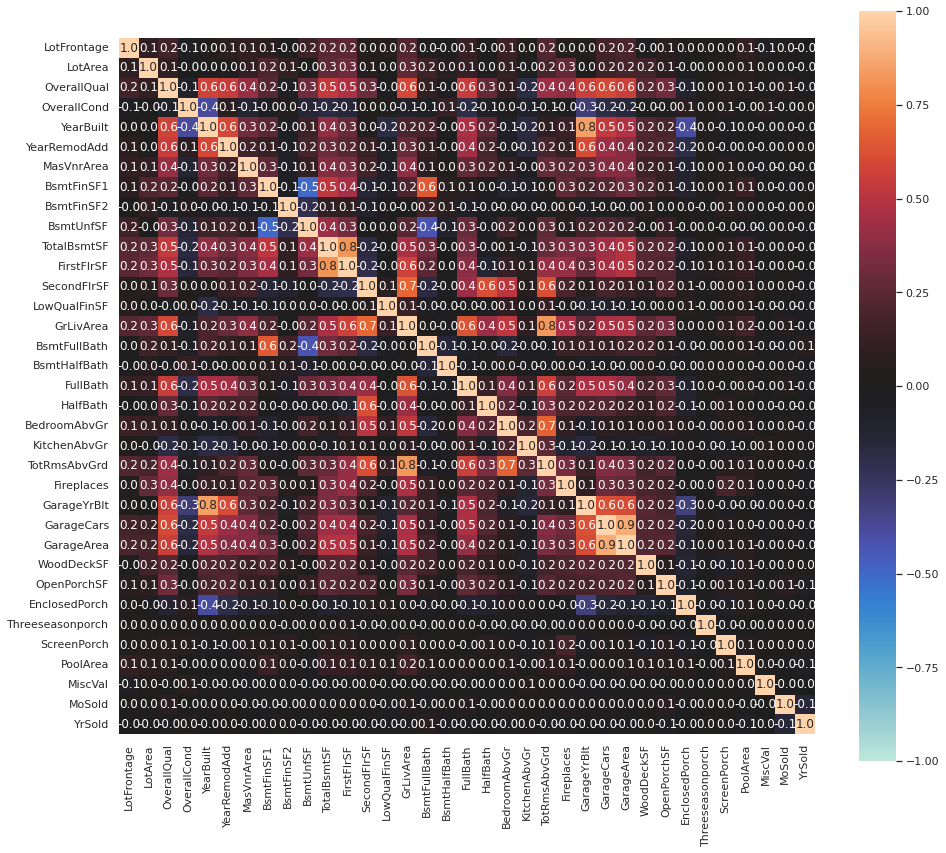

In [66]:
def corrplot(df, method="pearson"):
    corr = df.corr(method)
    plt.subplots(figsize=(14,12))
    sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="icefire", square=True, annot=True, fmt=".1f") # cmap="Blues"   
    
X = df_train.copy()
y = X.pop("SalePrice")   
corrplot(X[numeric_features], method="pearson")

In [68]:
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

In [69]:
print(df_train.shape)
df_test.shape

(1460, 213)


(1459, 203)

In [70]:
X_train = df_train.copy()
y_train = X_train.pop("SalePrice")

X_test = df_test.copy()

In [71]:
# Reindex the features of the test data aligning with the training data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [72]:
print(X_train.shape)
print(X_test.shape)

(1460, 212)
(1459, 212)


In [73]:
# As the categorical data are already one hot encoded, we do not need to encode again inside the function!
def rmsle(X, y, model=XGBRegressor()):
    X = X.copy()
    # X = pd.get_dummies(X, drop_first=True)
    score = -cross_val_score(model, X, np.log1p(y), cv=5, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

In [74]:
score = rmsle(X_train, y_train)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13858 RMSLE


# Models

In [79]:
# Optuna with XGBoost: Hyperparameter Tuning

#import optuna

#def objective(trial):
#    
#    xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-3, 1, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-3, 1, log=True),
#     )
#    xgb = XGBRegressor(**xgb_params)
#    return rmsle(X_train, y_train, xgb)

model_xgb = XGBRegressor(max_depth = 4, 
                         learning_rate = 0.03, 
                         n_estimators = 1255, 
                         min_child_weight = 1,
                         colsample_bytree = 0.69,
                         subsample = 0.41, 
                         reg_alpha = 0.005, 
                         reg_lambda = 0.02)

cv = cross_val_score(model_xgb,X_train,y_train,cv=3)

In [80]:
print(f'CV = {cv} \nMean = {cv.mean()}')

CV = [0.92450896 0.85175861 0.89680495] 
Mean = 0.8910241718869166


In [81]:
fited = model_xgb.fit(X_train, np.log(y_train))

In [82]:
pred = fited.predict(X_test)

In [86]:
basic_submission = pd.DataFrame({'Id': X_test.index, 'SalePrice': pred})
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('/home/siarhei/Programming/ML/Data/House-Prices/xgb_features', index=False)